In [1]:
pip install -U numexpr bottleneck

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install matplotlib==3.7.3 seaborn==0.12.2

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install kaggle

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import shutil

# Create the hidden .kaggle folder if it doesn't exist
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Copy kaggle.json from Desktop to ~/.kaggle
shutil.copyfile("/Users/jennifertran/Desktop/kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))

# Set permission so the API won't complain
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import matplotlib.ticker as mticker

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib.colors import LinearSegmentedColormap

In [6]:
!kaggle datasets download -d hudsonstuck/stockx-data-contest
!unzip -o stockx-data-contest.zip

Dataset URL: https://www.kaggle.com/datasets/hudsonstuck/stockx-data-contest
License(s): unknown
stockx-data-contest.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  stockx-data-contest.zip
  inflating: StockX-Data-Contest-2019-3.csv  


In [7]:
# Import dataset
df = pd.read_csv("StockX-Data-Contest-2019-3.csv")

# Data check
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Order Date    99956 non-null  object 
 1   Brand         99956 non-null  object 
 2   Sneaker Name  99956 non-null  object 
 3   Sale Price    99956 non-null  object 
 4   Retail Price  99956 non-null  object 
 5   Release Date  99956 non-null  object 
 6   Shoe Size     99956 non-null  float64
 7   Buyer Region  99956 non-null  object 
dtypes: float64(1), object(7)
memory usage: 6.1+ MB
None
  Order Date   Brand                                   Sneaker Name  \
0     9/1/17   Yeezy           Adidas-Yeezy-Boost-350-Low-V2-Beluga   
1     9/1/17   Yeezy    Adidas-Yeezy-Boost-350-V2-Core-Black-Copper   
2     9/1/17   Yeezy     Adidas-Yeezy-Boost-350-V2-Core-Black-Green   
3     9/1/17   Yeezy       Adidas-Yeezy-Boost-350-V2-Core-Black-Red   
4     9/1/17   Yeezy  Adidas-Yeezy-Boost-350-V2-Co

In [35]:
# Data reprocessing
df["Order Date"] = pd.to_datetime(df["Order Date"], errors="coerce")
df["Release Date"] = pd.to_datetime(df["Release Date"], errors="coerce")
df["Retail Price"] = df["Retail Price"].replace('[\$,]', '', regex=True).astype(float)
df["Sale Price"] = df["Sale Price"].replace('[\$,]', '', regex=True).astype(float)

In [36]:
print(f"Cleaned shape: {df.shape}")
print(df[["Order Date", "Release Date"]].dtypes)
print(df.head())

Cleaned shape: (99956, 12)
Order Date      datetime64[ns]
Release Date    datetime64[ns]
dtype: object
    Order Date   Brand                         Sneaker Name  Sale Price  \
112 2017-09-07   Yeezy  Adidas-Yeezy-Boost-350-Low-Moonrock      1230.0   
588 2017-09-26   Yeezy  Adidas-Yeezy-Boost-350-Low-Moonrock      1257.0   
764 2017-10-04   Yeezy  Adidas-Yeezy-Boost-350-Low-Moonrock      1000.0   
903 2017-10-12   Yeezy  Adidas-Yeezy-Boost-350-Low-Moonrock      1250.0   
919 2017-10-13   Yeezy  Adidas-Yeezy-Boost-350-Low-Moonrock      1250.0   

     Retail Price Release Date  Shoe Size Buyer Region  Days Since Release  \
112         200.0   2015-11-14       10.5     Michigan                 663   
588         200.0   2015-11-14        9.5       Nevada                 682   
764         200.0   2015-11-14        7.0   California                 690   
903         200.0   2015-11-14        6.5   California                 698   
919         200.0   2015-11-14        6.0      Florida  

In [37]:
# Calculate key metrics
df["Days Since Release"] = (df["Order Date"] - df["Release Date"]).dt.days
df["ROI"] = ((df["Sale Price"] - df["Retail Price"]) / df["Retail Price"]) * 100
df["Profit"] = df["Sale Price"] - df["Retail Price"]

In [38]:
# Execute key metrics
def key_metrics(df):
    print("Overall Market Metrics:")
    print(f"Average ROI: {df['ROI'].mean():.2f}%")
    print(f"Median ROI: {df['ROI'].median():.2f}%")
    print(f"Total Profit: ${df['Profit'].sum():.2f}")
    print(f"Total Sales Volume: {len(df)}")
    print(f"Unique Models: {df['Sneaker Name'].nunique()}")
    print("\n")
    
print(key_metrics(df))

Overall Market Metrics:
Average ROI: 124.82%
Median ROI: 70.45%
Total Profit: $23791640.00
Total Sales Volume: 99956
Unique Models: 50


None


In [39]:
print(f"Cleaned shape: {df.shape}")

Cleaned shape: (99956, 12)


In [40]:
# Time-based analysis
df = df.sort_values(by=["Sneaker Name", "Order Date"])
df["Month"] = df["Order Date"].dt.to_period("M")

In [41]:
# Top performing models
top_models = df.groupby("Sneaker Name").agg({
    "ROI": "mean",
    "Sale Price": "count", # Number of sales per models
    "Profit": "sum",
}).rename(columns={"Sale Price": "Num Sales"})

# Keep only models with 5+ sales
top_models = top_models[top_models["Num Sales"] >= 5]
top_models = top_models.sort_values("ROI", ascending=False).head(10)

print("Top 10 Models by ROI:")
print(top_models)
print("\n")

Top 10 Models by ROI:
                                                          ROI  Num Sales  \
Sneaker Name                                                               
Air-Jordan-1-Retro-High-Off-White-White            861.089625        313   
Air-Jordan-1-Retro-High-Off-White-Chicago          831.473684        755   
Nike-Air-Presto-Off-White                          672.534606        596   
Adidas-Yeezy-Boost-350-Low-Turtledove              665.830882         68   
Nike-Air-Force-1-Low-Virgil-Abloh-Off-White-AF100  550.344086         31   
Nike-Blazer-Mid-Off-White-Wolf-Grey                503.709936        288   
Nike-Blazer-Mid-Off-White                          434.980808        501   
Adidas-Yeezy-Boost-350-Low-Oxford-Tan              405.757143         70   
Adidas-Yeezy-Boost-350-Low-Moonrock                398.355000        100   
Adidas-Yeezy-Boost-350-Low-Pirate-Black-2016       392.118852        122   

                                                      Profit  
Sn

<function matplotlib.pyplot.show(close=None, block=None)>

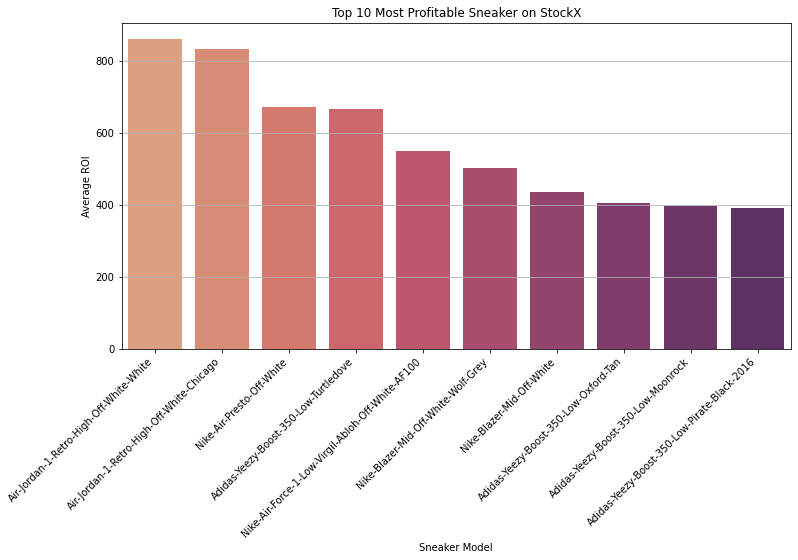

In [42]:
# Plot 10 most profitable sneaker models
plt.figure(figsize=(12, 6))
sns.barplot(x=top_models.head(10).index, y=top_models["ROI"].head(10), palette="flare")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Sneaker Model")
plt.ylabel("Average ROI")
plt.title("Top 10 Most Profitable Sneaker on StockX")
plt.grid(axis="y")
plt.show

In [43]:
print(f"Cleaned shape: {df.shape}")

Cleaned shape: (99956, 12)


In [44]:
## Brands Performance Analysis
brand_performance = df.groupby("Brand").agg({
    "ROI": "mean",
    "Sale Price": "mean",
    "Profit": "mean",
    "Sneaker Name": pd.Series.nunique
}).rename(columns={"Sneaker Name": "Unique Models"}).sort_values("ROI", ascending=False)

print("Brand Performance:")
print(brand_performance)
print("\n")

Brand Performance:
                  ROI  Sale Price      Profit  Unique Models
Brand                                                       
Off-White  282.865151  671.481291  492.103008             30
 Yeezy      63.953347  360.032552  140.158657             20




In [45]:
# Maturity curve - how sneakers perform over time
maturity_curve = df.groupby("Days Since Release").agg({
    "ROI": ["mean", "median", "std"],
    "Sale Price": ["mean", "count"]
})
print(maturity_curve)

                      ROI                    Sale Price      
                     mean median         std       mean count
Days Since Release                                           
-69                 837.5  837.5         NaN     1500.0     1
-64                 837.5  837.5         NaN     1500.0     1
-59                 230.0  230.0         NaN      825.0     1
-58                 260.0  260.0         NaN      900.0     1
-57                 491.5  491.5  400.929545     1085.0     2
...                   ...    ...         ...        ...   ...
 1271               522.5  522.5         NaN     1245.0     1
 1278               625.0  625.0         NaN     1450.0     1
 1304               475.0  475.0         NaN     1150.0     1
 1310               575.0  575.0         NaN     1350.0     1
 1321               550.0  550.0         NaN     1300.0     1

[1161 rows x 5 columns]


In [46]:
print(f"Cleaned shape: {df.shape}")

Cleaned shape: (99956, 12)


In [47]:
# Model-specific analysis
def analyze_model(dataframe, model_name):
    model_df = dataframe[dataframe["Sneaker Name"] == model_name].copy()

# Calculate moving averages
    model_df = model_df.set_index("Order Date").sort_index()
    model_df["SMA_7"] = model_df["Sale Price"].rolling(window=7).mean()
    model_df["EMA_7"] = model_df["Sale Price"].ewm(span=7, adjust=False).mean()

# Price momentum (rate of change)
    model_df["Volume"] = model_df.groupby(model_df.index.date)["Sale Price"].transform("count")

# Volatility
    model_df["Log Return"] = np.log(model_df["Sale Price"] / model_df["Sale Price"].shift(1))
    model_df["Volatility_7d"] = model_df["Log Return"].rolling(window=7).std() * np.sqrt(7)
    
    return model_df

In [48]:
# Monthly snapshots
monthly_performance = df.groupby(["Month", "Sneaker Name"]).agg({
    "ROI": "mean",
    "Sale Price": ["mean", "std", "count"]
}).reset_index()

# Convert to pivot for correlation analysis
pivot_df = monthly_performance.pivot(index="Month", columns="Sneaker Name", values=("ROI", "mean"))

# Calculate correlation matrix
corr_matrix = pivot_df.corr()

In [49]:
# Group by sneaker model to compute mean ROI and std deviation
model_features = df.groupby('Sneaker Name').agg({
    'ROI': ['mean', 'std'],
    'Sale Price': 'mean'
}).reset_index()

# Flatten column names
model_features.columns = ['Sneaker Name', 'ROI_mean', 'ROI_std', 'SalePrice_mean']

In [50]:
# Sharpe ratio (risk-adjusted return)
risk_free_rate = 5.5
model_features['Sharpe_Ratio'] = (model_features['ROI_mean'] - risk_free_rate) / model_features['ROI_std']

# Efficiency Score (for simplified frontier-like insight)
model_features['Efficiency_Score'] = model_features['ROI_mean'] / (1 + model_features['ROI_std'])

# Segment each model into risk/return categories
median_roi = model_features['ROI_mean'].median()
median_std = model_features['ROI_std'].median()

model_features['Risk_Return_Profile'] = np.where(
    (model_features['ROI_mean'] > median_roi) & (model_features['ROI_std'] < median_std),
    'Ideal (High Return, Low Risk)',
    np.where(
        (model_features['ROI_mean'] > median_roi) & (model_features['ROI_std'] > median_std),
        'Aggressive (High Return, High Risk)',
        np.where(
            (model_features['ROI_mean'] < median_roi) & (model_features['ROI_std'] < median_std),
            'Conservative (Low Return, Low Risk)',
            'Suboptimal (Low Return, High Risk)'
        )
    )
)

In [51]:
# Seasonality analysis
def analyze_seasonality(dataframe):
    # Resample to weekly data
    weekly_data = dataframe.groupby(pd.Grouper(freq='W'))["Sale Price"].mean().reset_index()
    weekly_data = weekly_data.set_index("Order Date")
    
    # Fill missing values using forward fill
    weekly_data = weekly_data.fillna(method="ffill")
    
    # Decompose time series
    if len(weekly_data) >= 52:  # Need at least a year of data
        decomposition = seasonal_decompose(weekly_data, model='additive', period=52)
        return decomposition
    else:
        return None

In [52]:
# Calculate "Sneaker Beta" - how individual models move relative to the overall market
def calculate_beta(df, sneaker_name):
    # Create market index (equal-weighted average of all sneakers)
    market_daily = df.groupby("Order Date")["Sale Price"].mean()
    market_returns = market_daily.pct_change().dropna()
    
    # Get individual sneaker returns
    sneaker_data = df[df["Sneaker Name"] == sneaker_name]
    sneaker_daily = sneaker_data.groupby("Order Date")["Sale Price"].mean()
    sneaker_returns = sneaker_daily.pct_change().dropna()
    
    # Align dates
    aligned_data = pd.concat([sneaker_returns, market_returns], axis=1).dropna()
    
    if aligned_data.empty or len(aligned_data) < 10:
        return None
    
    # Calculate beta
    X = aligned_data.iloc[:, 1].values.reshape(-1, 1)
    y = aligned_data.iloc[:, 0].values
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    return model.params[1]  # Beta coefficient

In [53]:
# Segmented trend analysis
def segment_trends(df):
    # Get top brands
    top_brands = df["Brand"].value_counts().nlargest(5).index
    
    # Calculate metrics by brand and time
    brand_trends = df[df["Brand"].isin(top_brands)].groupby(["Brand", pd.Grouper(key="Order Date", freq="M")]).agg({
        "ROI": "mean",
        "Sale Price": "mean",
        "Profit": ["mean", "sum"],
        "Sneaker Name": "count"
    })
    
    return brand_trends

In [54]:
def analyze_liquidity(df):
    # Prepare data
    liquidity_df = df.copy()
    liquidity_df = liquidity_df.sort_values(["Sneaker Name", "Order Date"])
    liquidity_df["Days_Between_Sales"] = liquidity_df.groupby("Sneaker Name")["Order Date"].diff().dt.days

    # Aggregate
    liquidity_metrics = liquidity_df.groupby("Sneaker Name")["Days_Between_Sales"].agg(["median", "mean", "count"])
    liquidity_metrics.columns = ["Median_Days_Between_Sales", "Mean_Days_Between_Sales", "Number_Of_Sales"]

    # Improved Liquidity Score
    liquidity_metrics["Liquidity_Score"] = (
        liquidity_metrics["Median_Days_Between_Sales"] + 1
    ) / np.log1p(liquidity_metrics["Number_Of_Sales"])

    return liquidity_metrics.sort_values("Liquidity_Score")

In [55]:
# Visualization functions OF White
def plot_price_trend(df, model_name):
    model_data = analyze_model(df, model_name)
    plt.figure(figsize=(12, 6))
    
    plt.plot(model_data.index, model_data["Sale Price"], 'o-', alpha=0.5, label="Sale Price")
    plt.plot(model_data.index, model_data["SMA_7"], label="7-Day SMA")
    plt.plot(model_data.index, model_data["EMA_7"], label="7-Day EMA")
    
    plt.title(f"Price Trend for {model_name}")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

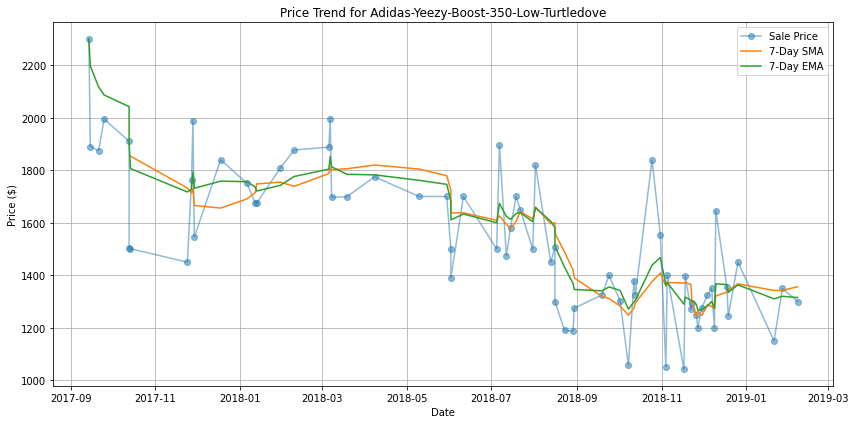

In [56]:
# Visualization function for a given model name
def plot_price_trend(df, model_name):
    model_data = analyze_model(df, model_name)
    plt.figure(figsize=(12, 6))
    
    plt.plot(model_data.index, model_data["Sale Price"], 'o-', alpha=0.5, label="Sale Price")
    plt.plot(model_data.index, model_data["SMA_7"], label="7-Day SMA")
    plt.plot(model_data.index, model_data["EMA_7"], label="7-Day EMA")
    
    plt.title(f"Price Trend for {model_name}")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_price_trend(df, "Adidas-Yeezy-Boost-350-Low-Turtledove")

In [57]:
def plot_roi_heatmap(df):

    # Bin the days since release
    heatmap_data = df.copy()
    bins = [0, 30, 90, 180, 365, float('inf')]
    labels = ['0-30', '31-90', '91-180', '181-365', '365+']
    heatmap_data['Age_Group'] = pd.cut(heatmap_data['Days Since Release'], bins=bins, labels=labels)

    # Create pivot table: Brand x Age Group
    pivot = heatmap_data.pivot_table(
        index="Brand",
        columns="Age_Group",
        values="ROI",
        aggfunc="mean",
        observed=False  # Silence future warning
    )

    # Plot heatmap
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot, annot=True, cmap='flare', vmin=50, vmax=700, fmt='.1f')
    plt.title('ROI Heatmap by Brand and Product Age')
    plt.xlabel("Product Age Group (days since release)")
    plt.ylabel("Brand")
    plt.tight_layout()
    plt.show()

In [58]:
def plot_portfolio_performance(df):

    df['Order Date'] = pd.to_datetime(df['Order Date'])

    # Monthly aggregation
    monthly_port = df.groupby(pd.Grouper(key='Order Date', freq='ME')).agg({
        'ROI': 'mean',
        'Profit': 'sum',
        'Sale Price': 'count'
    }).rename(columns={
        'ROI': 'Average_ROI',
        'Profit': 'Total_Profit',
        'Sale Price': 'Number_of_Sales'
    }).reset_index()

    monthly_port['Order Date'] = pd.to_datetime(monthly_port['Order Date'])
    monthly_port = monthly_port.sort_values('Order Date')

    # Plot
    plt.style.use('default')
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Average ROI (%)', color='#142D4C')
    ax1.plot(monthly_port['Order Date'], monthly_port['Average_ROI'], color='#427898')
    ax1.tick_params(axis='y', labelcolor='#142D4C')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Total Profit ($)', color='#E16A54')
    ax2.plot(monthly_port['Order Date'], monthly_port['Total_Profit'], color='#E16A54')
    ax2.tick_params(axis='y', labelcolor='#E16A54')
    ax2.ticklabel_format(style='plain', axis='y')

    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))
    fig.autofmt_xdate()
    plt.title('Portfolio Performance Over Time')
    plt.grid(True)
    fig.tight_layout()
    plt.show()

In [59]:
# Check for problematic values
print(model_features.isna().sum())  # See which columns have NaNs

# Drop rows with NaN or Inf (safest approach for clustering)
model_features_clean = model_features.replace([np.inf, -np.inf], np.nan)
model_features_clean = model_features_clean.dropna(subset=['ROI_mean', 'ROI_std', 'SalePrice_mean']).copy()

# Select features for clustering
features = model_features_clean[['ROI_mean', 'ROI_std', 'SalePrice_mean']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
model_features_clean['Cluster'] = kmeans.fit_predict(X_scaled)

# Standardize the data
scaler = StandardScaler()
X_scaled = StandardScaler().fit_transform(features)

print(model_features_clean.columns)

Sneaker Name           0
ROI_mean               0
ROI_std                0
SalePrice_mean         0
Sharpe_Ratio           0
Efficiency_Score       0
Risk_Return_Profile    0
dtype: int64
Index(['Sneaker Name', 'ROI_mean', 'ROI_std', 'SalePrice_mean', 'Sharpe_Ratio',
       'Efficiency_Score', 'Risk_Return_Profile', 'Cluster'],
      dtype='object')


In [60]:
# Run KMeans and assign cluster labels
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
model_features_clean['Cluster'] = kmeans.fit_predict(X_scaled)

# Group by 'Cluster'
numeric_cols = model_features_clean.select_dtypes(include='number').columns
cluster_summary = model_features_clean.groupby("Cluster")[numeric_cols].mean()

print(cluster_summary)

           ROI_mean     ROI_std  SalePrice_mean  Sharpe_Ratio  \
Cluster                                                         
0         65.011399   28.806767      337.869808      2.406978   
1        406.923399  108.083006      862.029763      4.023345   
2        757.732199  183.310459     1590.896855      4.416161   
3        250.188793   50.546798      668.955761      5.244584   

         Efficiency_Score  Cluster  
Cluster                             
0                2.542705      0.0  
1                4.035309      1.0  
2                4.420916      2.0  
3                5.243592      3.0  


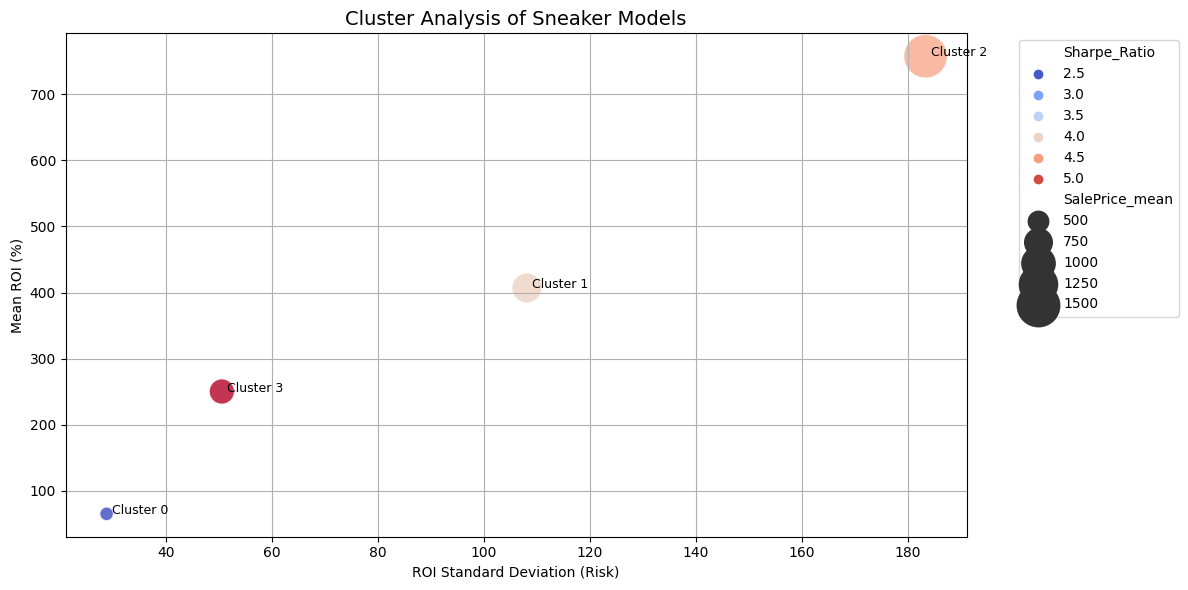

In [66]:
# Create a DataFrame with the provided cluster data
cluster_data = {
    'Cluster': [0, 1, 2, 3],
    'ROI_mean': [65.011399, 406.923399, 757.732199, 250.188793],
    'ROI_std': [28.806767, 108.083006, 183.310459, 50.546798],
    'SalePrice_mean': [337.869808, 862.029763, 1590.896855, 668.955761],
    'Sharpe_Ratio': [2.406978, 4.023345, 4.416161, 5.244584],
    'Efficiency_Score': [2.542705, 4.035309, 4.420916, 5.243592]
}

df_clusters = pd.DataFrame(cluster_data)

# Plot: ROI_mean vs ROI_std, size by SalePrice_mean, color by Sharpe Ratio
plt.figure(figsize=(12, 6))
scatter = sns.scatterplot(
    data=df_clusters,
    x='ROI_std', y='ROI_mean',
    size='SalePrice_mean',
    hue='Sharpe_Ratio',
    palette='coolwarm',
    sizes=(100, 1000),
    legend='brief',
    alpha=0.8
)

# Annotate points with cluster number
for i, row in df_clusters.iterrows():
    plt.text(row['ROI_std'] + 1, row['ROI_mean'], f"Cluster {int(row['Cluster'])}", fontsize=9)

# Title and labels
plt.title('Cluster Analysis of Sneaker Models', fontsize=14)
plt.xlabel('ROI Standard Deviation (Risk)')
plt.ylabel('Mean ROI (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.grid(True)
plt.show()

In [64]:
# Execute main analysis
def main_analysis(df):
    
    # Calculate overall market metrics
    print("Overall Market Metrics:")
    print(f"Average ROI: {df['ROI'].mean():.2f}%")
    print(f"Median ROI: {df['ROI'].median():.2f}%")
    print(f"Total Profit: ${df['Profit'].sum():.2f}")
    print(f"Total Sales Volume: {len(df)}")
    print(f"Unique Models: {df['Sneaker Name'].nunique()}")
    print("\n")
    
    # Top performing models
    top_models = df.groupby("Sneaker Name").agg({
        "ROI": "mean",
        "Profit": "sum",
        "Sale Price": "count"
    }).sort_values("ROI", ascending=False).head(10)
    print("Top 10 Models by ROI:")
    print(top_models)
    print("\n")
    
    # Brand analysis
    print("Brand Performance:")
    print(brand_performance)
    print("\n")
    
    # Liquidity analysis
    liquidity = analyze_liquidity(df)
    print("Most Liquid Models:")
    print(liquidity.head(10))
    print("\n")
    
    # Visualizations
    plot_roi_heatmap(df)
    plot_portfolio_performance(df)
    
    # Individual model analysis for top models
    top_model = top_models.index[0]
    plot_price_trend(df, top_model)

Overall Market Metrics:
Average ROI: 124.82%
Median ROI: 70.45%
Total Profit: $23791640.00
Total Sales Volume: 99956
Unique Models: 50


Top 10 Models by ROI:
                                                          ROI     Profit  \
Sneaker Name                                                               
Air-Jordan-1-Retro-High-Off-White-White            861.089625   512090.0   
Air-Jordan-1-Retro-High-Off-White-Chicago          831.473684  1192749.0   
Nike-Air-Presto-Off-White                          672.534606   641329.0   
Adidas-Yeezy-Boost-350-Low-Turtledove              665.830882    90553.0   
Nike-Air-Force-1-Low-Virgil-Abloh-Off-White-AF100  550.344086    25591.0   
Nike-Blazer-Mid-Off-White-Wolf-Grey                503.709936   188589.0   
Nike-Blazer-Mid-Off-White                          434.980808   283303.0   
Adidas-Yeezy-Boost-350-Low-Oxford-Tan              405.757143    56806.0   
Adidas-Yeezy-Boost-350-Low-Moonrock                398.355000    79671.0   
Adida

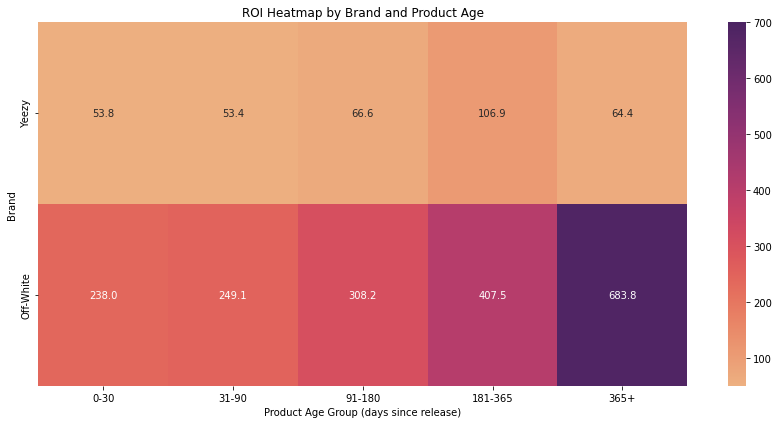

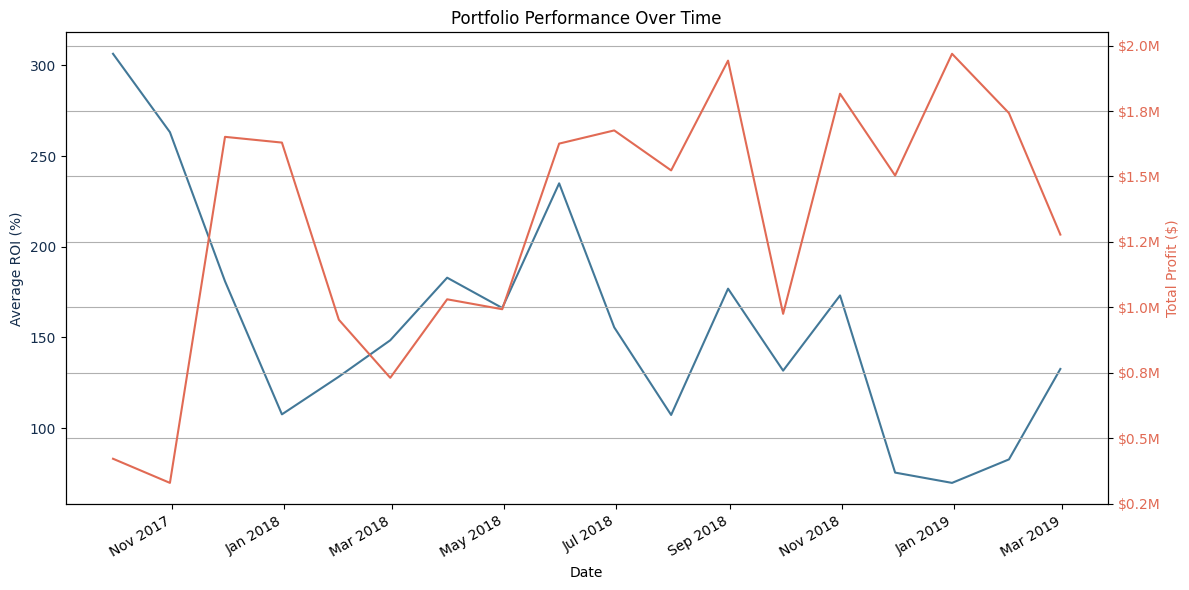

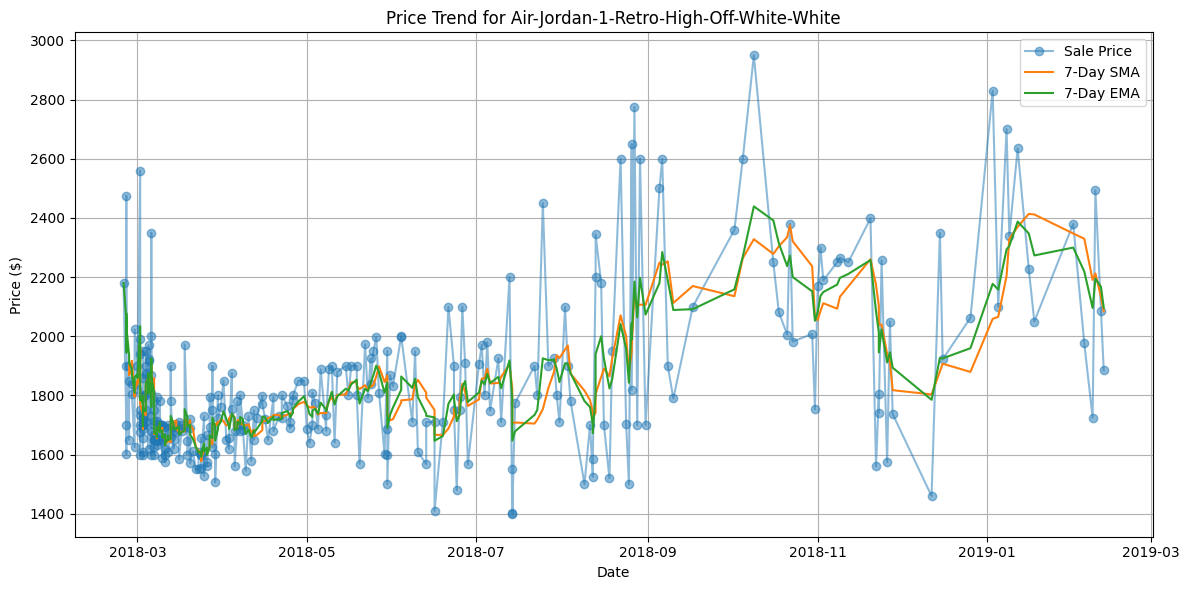

In [65]:
if __name__=="__main__":
    main_analysis(df)